# Analysis of Jakarta Fire Hydrant Dataset 2023 Period

In this project, I'm interested in creating a heatmap or choropleth map as technical excercise.

In the meantime, I also look for interesting insights contained in recently published data of state owned fire hyrants at [Satu Data Jakarta](https://satudata.jakarta.go.id/) open database.

I think these questions can serve as the core of this analysis:
- What is the majority condition of fire hydrants in Jakarta?
- Which regency have the most highest amount in terms of damaged fire hydrants?
- Which regency has the most highest amount satisfactory fire hydrants?
- Which district have the most highest amount in terms of damaged fire hydrants?
- Which district has the most highest amount satisfactory fire hydrants?

## Data
The dataset are records of condition for each state owned fire hydrants across Jakarta which composed of:
<ol>
<li>periode_data: Year period of the record</li>
<li>wilayah: Regency of the fire hydrant location</li>
<li>kecamatan: District of the fire hydrant location</li>
<li>kelurahan: Subdistrict/village of the fire hydrant location</li>
<li>kode_hidran: Hydrant code, the column did not have any description in the database</li>
<li>nama_hidran: Cost of product in US Dollars</li>
<li>longitude and latitude: Coodinates for each fire hydrant</li>
<li>alamat: Address of the fire hydrant</li>
<li>kondisi: Fire hydrant condition, composed of:</li>
    <ul>
    <li>Baik: Good or satisfactory</li>
    <li>Rusak ringan: Minor damage</li>
    <li>Rusak berat: Major damage</li>
    </ul>
</ol>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

## Data Overview

In [2]:
df_2023_1 = pd.read_csv('Data_Lokasi Hidran.csv')

In [3]:
df_2023_1.head()

,periode_data,wilayah,kecamatan,kelurahan,kode_hidran,nama_hidran,longitude,latitude,alamat,kondisi
0,NaN,Jakarta Utara,Tanjung Priok,Sunter Agung,1.320502e+11,Hidran Kota,"106,8693596","-6,1438657",Sunter Agung Jln. Danau Agung Tengah 4,Rusak Ringan
1,NaN,Jakarta Utara,Tanjung Priok,Sunter Agung,1.320502e+11,Hidran Kota,"106,8645249","-6,1447285",Sunter Agung Jln. Danau Agung Tengah (Depan P...,Rusak Ringan
2,NaN,Jakarta Utara,Tanjung Priok,Sunter Agung,1.320502e+11,Hidran Kota,NaN,NaN,Sunter Agung Jln. Danau Agung Tengah III (Dep...,Rusak Ringan
3,NaN,Jakarta Utara,Tanjung Priok,Sunter Jaya,1.320502e+11,Hidran Kota,"106,8839911","-6,1271519",Sunter Agung Jln. Mitra Sunter Boulevard,Rusak Ringan
4,NaN,Jakarta Utara,Tanjung Priok,Sunter Agung,1.320502e+11,Hidran Kota,NaN,NaN,Sunter Agung Jln. Raya Tugu (Depan Sekolah Mar...,Rusak Ringan


In [4]:
df_2023_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10880 entries, 0 to 10879
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   periode_data  9696 non-null   float64
 1   wilayah       10879 non-null  object 
 2   kecamatan     10879 non-null  object 
 3   kelurahan     10879 non-null  object 
 4   kode_hidran   10879 non-null  float64
 5   nama_hidran   10879 non-null  object 
 6   longitude     9498 non-null   object 
 7   latitude      9498 non-null   object 
 8   alamat        10879 non-null  object 
 9   kondisi       10825 non-null  object 
dtypes: float64(2), object(8)
memory usage: 850.1+ KB


Dataset contains a lot of null or missing values in most columns.

## Data Cleaning

Removing kode_hidran, nama_hidran, alamat, kelurahan, and coordinates as these columns are not used in analysis.

In [5]:
df_2023 = df_2023_1.copy()
df_2023.drop(labels = ['kode_hidran', 'nama_hidran', 'alamat', 'kelurahan', 'longitude', 'latitude'], inplace = True, axis = 1)
df_2023.head()

,periode_data,wilayah,kecamatan,kondisi
0,NaN,Jakarta Utara,Tanjung Priok,Rusak Ringan
1,NaN,Jakarta Utara,Tanjung Priok,Rusak Ringan
2,NaN,Jakarta Utara,Tanjung Priok,Rusak Ringan
3,NaN,Jakarta Utara,Tanjung Priok,Rusak Ringan
4,NaN,Jakarta Utara,Tanjung Priok,Rusak Ringan


Translating from Indonesian to English

In [6]:
df_2023.rename(columns = {'periode_data' : 'period', 'wilayah' : 'regency', 'kecamatan' : 'district', 'kondisi' : 'condition'}, inplace = True)
df_2023.replace(['Jakarta Utara', 'Jakarta Barat', 'Jakarta Pusat',
       'Jakarta Selatan', 'Jakarta Timur'], ['North Jakarta', 'West Jakarta', 'Central Jakarta', 'South Jakarta', 'East Jakarta'], inplace = True)

Filling null values in period column

In [7]:
df_2023['period'].fillna(2023, inplace= True)
df_2023['period'] = df_2023['period'].astype('int64')

Inconsistencies in typing condition of each fire hydrant results in 8 unique data values including null inside condition column.

In [8]:
df_2023['condition'].unique()

array(['Rusak Ringan', 'Baik', nan, 'Rusak Berat', 'Rusak berat',
       'Rusak ringan', 'Rusaak Ringan', 'Baik ', 'baik'], dtype=object)

Fixing inconsistencies in the condition column

In [9]:
df_2023['condition'] = df_2023['condition'].str.lower()
df_2023['condition'] = df_2023['condition'].replace(['rusaak ringan', 'baik '], ['rusak ringan', 'baik'])
df_2023['condition'] = df_2023['condition'].replace(['baik', 'rusak ringan', 'rusak berat'], ['good', 'minor damage', 'major damage'])
df_2023['condition'].unique()

array(['minor damage', 'good', nan, 'major damage'], dtype=object)

Fixing inconsistencies in district column

In [10]:
df_2023['district'] = df_2023['district'].str.capitalize()
df_2023['district'] = df_2023['district'].str.rstrip()

Filling null values in condition column

In [11]:
df_2023['condition'].value_counts(normalize= True)

minor damage    0.631039
good            0.308637
major damage    0.060323
Name: condition, dtype: float64

As majority of frequency of condition is dominated by minor damage (mode) then null value inside condition column can be filled by minor damage.

In [12]:
df_2023['condition'].fillna('minor damage', inplace = True)
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10880 entries, 0 to 10879
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   period     10880 non-null  int64 
 1   regency    10879 non-null  object
 2   district   10879 non-null  object
 3   condition  10880 non-null  object
dtypes: int64(1), object(3)
memory usage: 340.1+ KB


Checking last null value on regency and district columns.

In [13]:
np.where(pd.isnull(df_2023['regency']))

(array([632], dtype=int64),)

The null value is on row 632 of the dataset.

In [14]:
df_2023.iloc[632]

period               2023
regency               NaN
district              NaN
condition    minor damage
Name: 632, dtype: object

As both regency and district did not have any values so it's safer to drop the row number 632.

In [15]:
df_2023.drop(632, inplace = True)
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10879 entries, 0 to 10879
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   period     10879 non-null  int64 
 1   regency    10879 non-null  object
 2   district   10879 non-null  object
 3   condition  10879 non-null  object
dtypes: int64(1), object(3)
memory usage: 425.0+ KB


Fixing mistype in Taman Sari district:

In [16]:
df_2023.replace(['Tamansari'], ['Taman sari'], inplace = True)

## EDA


Recalling proportion of each condition in whole Jakarta:

In [17]:
df_2023['condition'].value_counts(normalize= True)

minor damage    0.632871
good            0.307105
major damage    0.060024
Name: condition, dtype: float64

In [18]:
df_2023['condition'].count()

10879

10879 fire hydrants distributed across Jakarta, 63% fire hydrants have minor damage, 31% have major damage and the rest 6% is satisfactory.

Checking the proportion of fire hydrant condition in each regency.

In [19]:
z = df_2023['regency'].unique()
for i in range(len(z)):
    print('Proportions of Regency: ',z[i],'\n',df_2023[df_2023['regency'] == z[i]]['condition'].value_counts(normalize = True))

Proportions of Regency:  North Jakarta 
 minor damage    0.913357
major damage    0.064982
good            0.021661
Name: condition, dtype: float64
Proportions of Regency:  West Jakarta 
 minor damage    0.689582
good            0.310418
Name: condition, dtype: float64
Proportions of Regency:  Central Jakarta 
 minor damage    0.588578
good            0.213168
major damage    0.198254
Name: condition, dtype: float64
Proportions of Regency:  South Jakarta 
 good            0.540636
minor damage    0.459364
Name: condition, dtype: float64
Proportions of Regency:  East Jakarta 
 minor damage    0.606632
good            0.393368
Name: condition, dtype: float64


In [20]:
for i in range(len(z)):
    print('Amount of Fire Hydrants per Regency: ',z[i],'\n',df_2023[df_2023['regency'] == z[i]]['condition'].count())

Amount of Fire Hydrants per Regency:  North Jakarta 
 1662
Amount of Fire Hydrants per Regency:  West Jakarta 
 1411
Amount of Fire Hydrants per Regency:  Central Jakarta 
 2749
Amount of Fire Hydrants per Regency:  South Jakarta 
 1981
Amount of Fire Hydrants per Regency:  East Jakarta 
 3076


Majority of fire hydrants with minor damage are located in North Jakarta, with 0.91% of total hydrants in North Jakarta have minor damage.
As for fire hydrants with major damage, Central Jakarta has the highest population of major damage on fire hydrants compared to other regencies.

In [21]:
pd.set_option('display.max_rows', None)
district_df = pd.DataFrame(df_2023.groupby(['district'])['condition'].value_counts(normalize= True).rename_axis(['district', 'condition'])).rename(columns = {'condition': 'total'}).copy().reset_index(level = ['district', 'condition'])
district_df

,district,condition,total
0,Cakung,minor damage,0.620865
1,Cakung,good,0.379135
2,Cempaka putih,minor damage,0.666667
3,Cempaka putih,major damage,0.333333
4,Cengkareng,minor damage,0.619469
5,Cengkareng,good,0.380531
6,Cilandak,good,0.684211
7,Cilandak,minor damage,0.315789
8,Cilincing,minor damage,0.824561
9,Cilincing,major damage,0.140351


Districts with largest percentage of fire hydrants with major damage are Cempaka Putih at 33.3%, followed by Sawah Besar at 32%, Menteng at 31,5%, Kemayoran at 20%, Tanah Abang at 18%, Cilincing at 14%, and Senen at 11,5%.

The districts with smallest percentage of fire hydrants with major damage are in Tanjung Priok at 2%, Kelapa Gading at 3%, Koja at 5%, Gambir at 6%, and Johar Baru at 8%.

All fire hydrants in Pademangan, Penjaringan, and Pesanggrahan suffered from minor damage.

There are no district with either only populated with satisfactory fire hydrants or populated with fire hydrants with major damage.



## Visualization

### Pie Chart of Fire Hydrant Conditions of Whole Jakarta

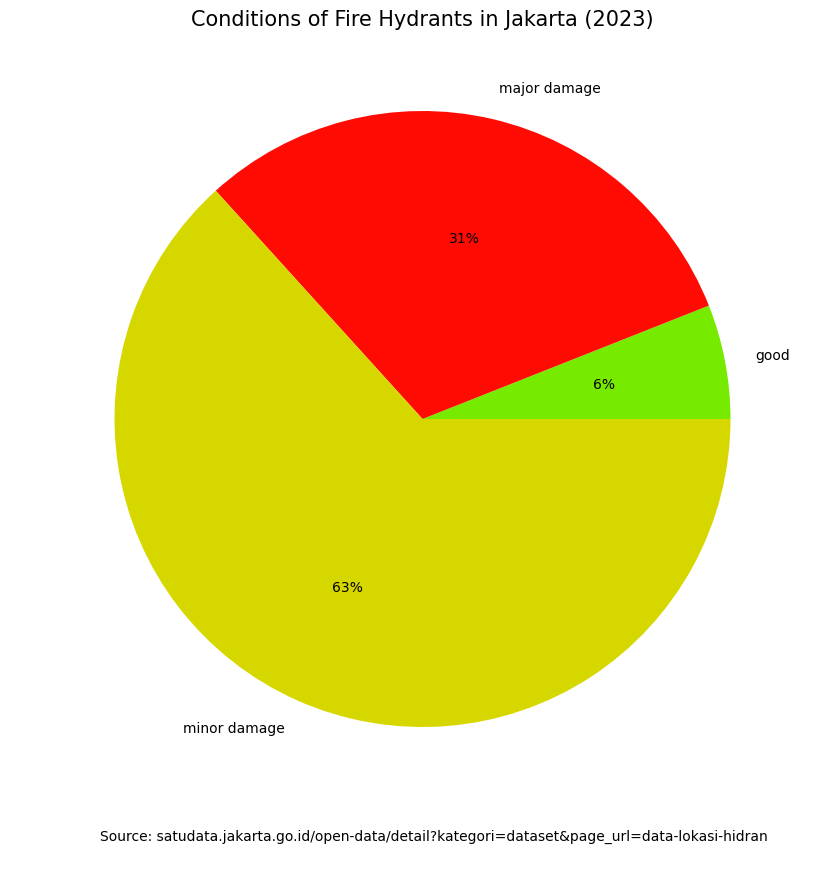

In [49]:
labels = df_2023['condition'].sort_values().unique()
data = df_2023.value_counts(subset = 'condition', ascending = True)
source = 'Source: satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-lokasi-hidran'
colors_pie = ['#76EB00', '#FF0B04', '#D7D700']

fig, ax = plt.subplots(figsize = (10,10))
plt.pie(data.to_numpy(), labels = labels, colors = sns.set_palette(sns.color_palette(colors_pie)), autopct = '%.0f%%')
ax.set_title('Conditions of Fire Hydrants in Jakarta (2023)', fontsize = 15)
ax.annotate(source, xy = (0.1, .04), xycoords= 'figure fraction', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize = 10)
plt.show()

As shown in pie chart above and normalized frequency of fire hydrants, 63% of fire hydrants in Jakarta sustained minor damage and only 6% of fire hydrants are in satisfactory condition. The rest, 31% fire hydrants of Jakarta have sustained major damage.

In terms of amount of fire hydrants:

- 3341 fire hydrants are in satisfactory condition
- 6885 fire hydrants have sustained minor damage
- 653 fire hydrants have sustained major damage

Loading GeoJSON file for choropleth map:

In [23]:
geo_df_jak = gpd.read_file('id-jk.geojson')
geo_df_jak.replace(['Kota Jakarta Selatan', 'Kota Jakarta Barat', 'Kota Jakarta Utara', 'Kota Jakarta Timur', 'Kota Jakarta Pusat'], ['South Jakarta', 'West Jakarta', 'North Jakarta', 'East Jakarta', 'Central Jakarta'], inplace = True)

Total count of all fire hydrants per regency grouped into each condition:

In [24]:
df_t = df_2023.groupby(['regency', 'condition']).count().copy()
df_t.drop(['district'], inplace = True, axis = 1)
df_t.rename(columns = {'period': 'total'}, inplace = True)
df_t

total
regency         condition          
Central Jakarta good            586
                major damage    545
                minor damage   1618
East Jakarta    good           1210
                minor damage   1866
North Jakarta   good             36
                major damage    108
                minor damage   1518
South Jakarta   good           1071
                minor damage    910
West Jakarta    good            438
                minor damage    973

In [25]:
df_pie = df_t.reset_index(level = ['regency', 'condition']).copy()

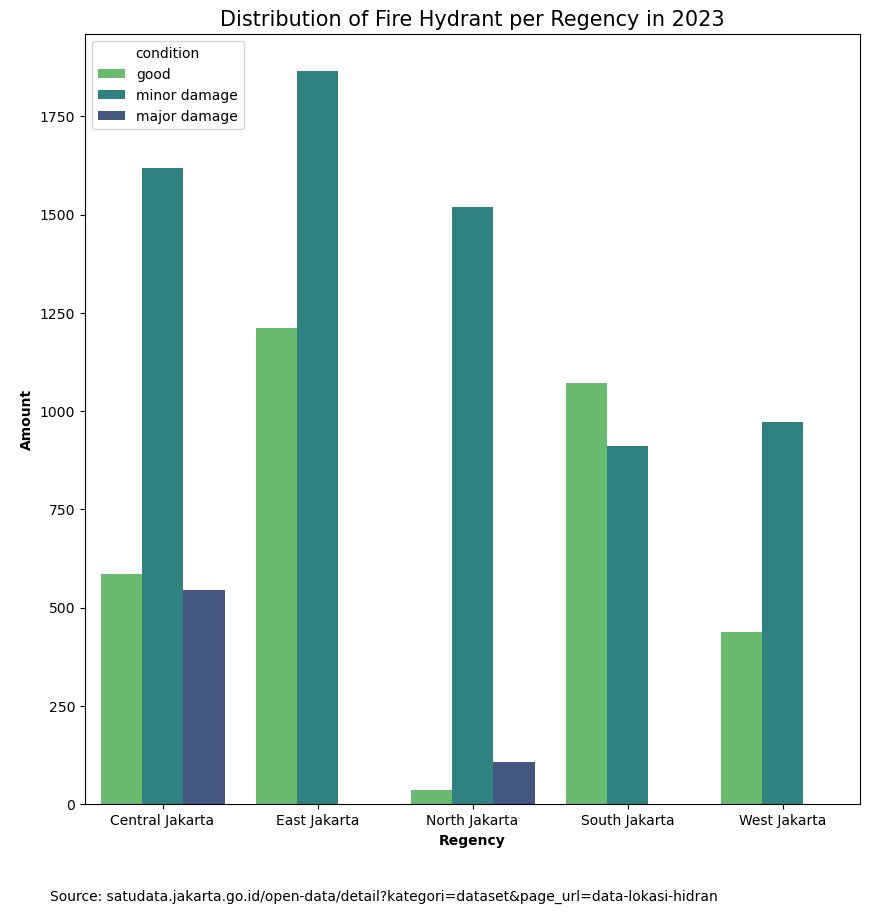

In [26]:
fig_bar, ax_bar = plt.subplots(figsize = (10,10))
sns.barplot(
    data = df_pie,
    x = 'regency',
    y = 'total',
    hue = 'condition',
    hue_order = ['good', 'minor damage', 'major damage'],
    orient = 'v',
    palette = 'viridis_r'
)
ax_bar.set_title('Distribution of Fire Hydrant per Regency in 2023', fontsize = 15)
ax_bar.set_xlabel('Regency', fontweight = 'bold')
ax_bar.set_ylabel('Amount', fontweight = 'bold')
ax_bar.annotate(source, xy = (0.05, .01), xycoords= 'figure fraction', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize = 10)
plt.show()

Comparing the distribution of all fire hydrants per regency shows:
- East Jakarta has the largest amount of fire hydrants with both fire hydrants in satisfactory condition and fire hydrants with minor damage.
- Fire hydrants with major damage can be found only in Central Jakarta and North Jakarta. The rest three regencies did not have any fire hydrants that sustained major damage.
- Only in South Jakarta Regency the amount of satisfactory fire hydrant outpaced the amount of fire hydrants with minor damage. All 4 other regencies have the reversed situation, amount of fire hydrants with minor damage outpaced the amount of fire hydrants in satisfactory condition.
- North Jakarta has the lowest amount of fire hydrant in satisfactory condition.

### Choropleth Map of Fire Hydrant per Regency

In [27]:
merged_df = pd.merge(left = geo_df_jak, right = df_pie, how = 'left', left_on = 'name', right_on = 'regency')

In [28]:
merged_df_dam = merged_df[merged_df['condition'] != 'good'].copy().reset_index(drop = True)
merged_df_dam.replace(['minor damage', 'major damage'], ['damaged', 'damaged'], inplace = True)
merged_df_dam = merged_df_dam.groupby(['name', 'geometry', 'condition']).sum(numeric_only = True).reset_index()
merged_df_dam.drop(columns = ['geometry'], axis = 1, inplace = True)
merged_df_dam = pd.merge(left = geo_df_jak, right = merged_df_dam, how = 'left', left_on = 'name', right_on = 'name')


### Tweaking cmap color for Choropleth map
Choropleth map uses sequential cmaps which may not work well with white background for visualization as there are some values will be visualized with white color.

In [29]:
cmap_d = plt.cm.Reds(np.arange(plt.cm.Reds.N))
cmap_d[:,0:3] *= 0.9
cmap_d = ListedColormap(cmap_d)

In [30]:
cmap_g = plt.cm.Greens(np.arange(plt.cm.Greens.N))
cmap_g[:,0:3] *= 0.9
cmap_g = ListedColormap(cmap_g)

### Choropleth Map of whole Jakarta

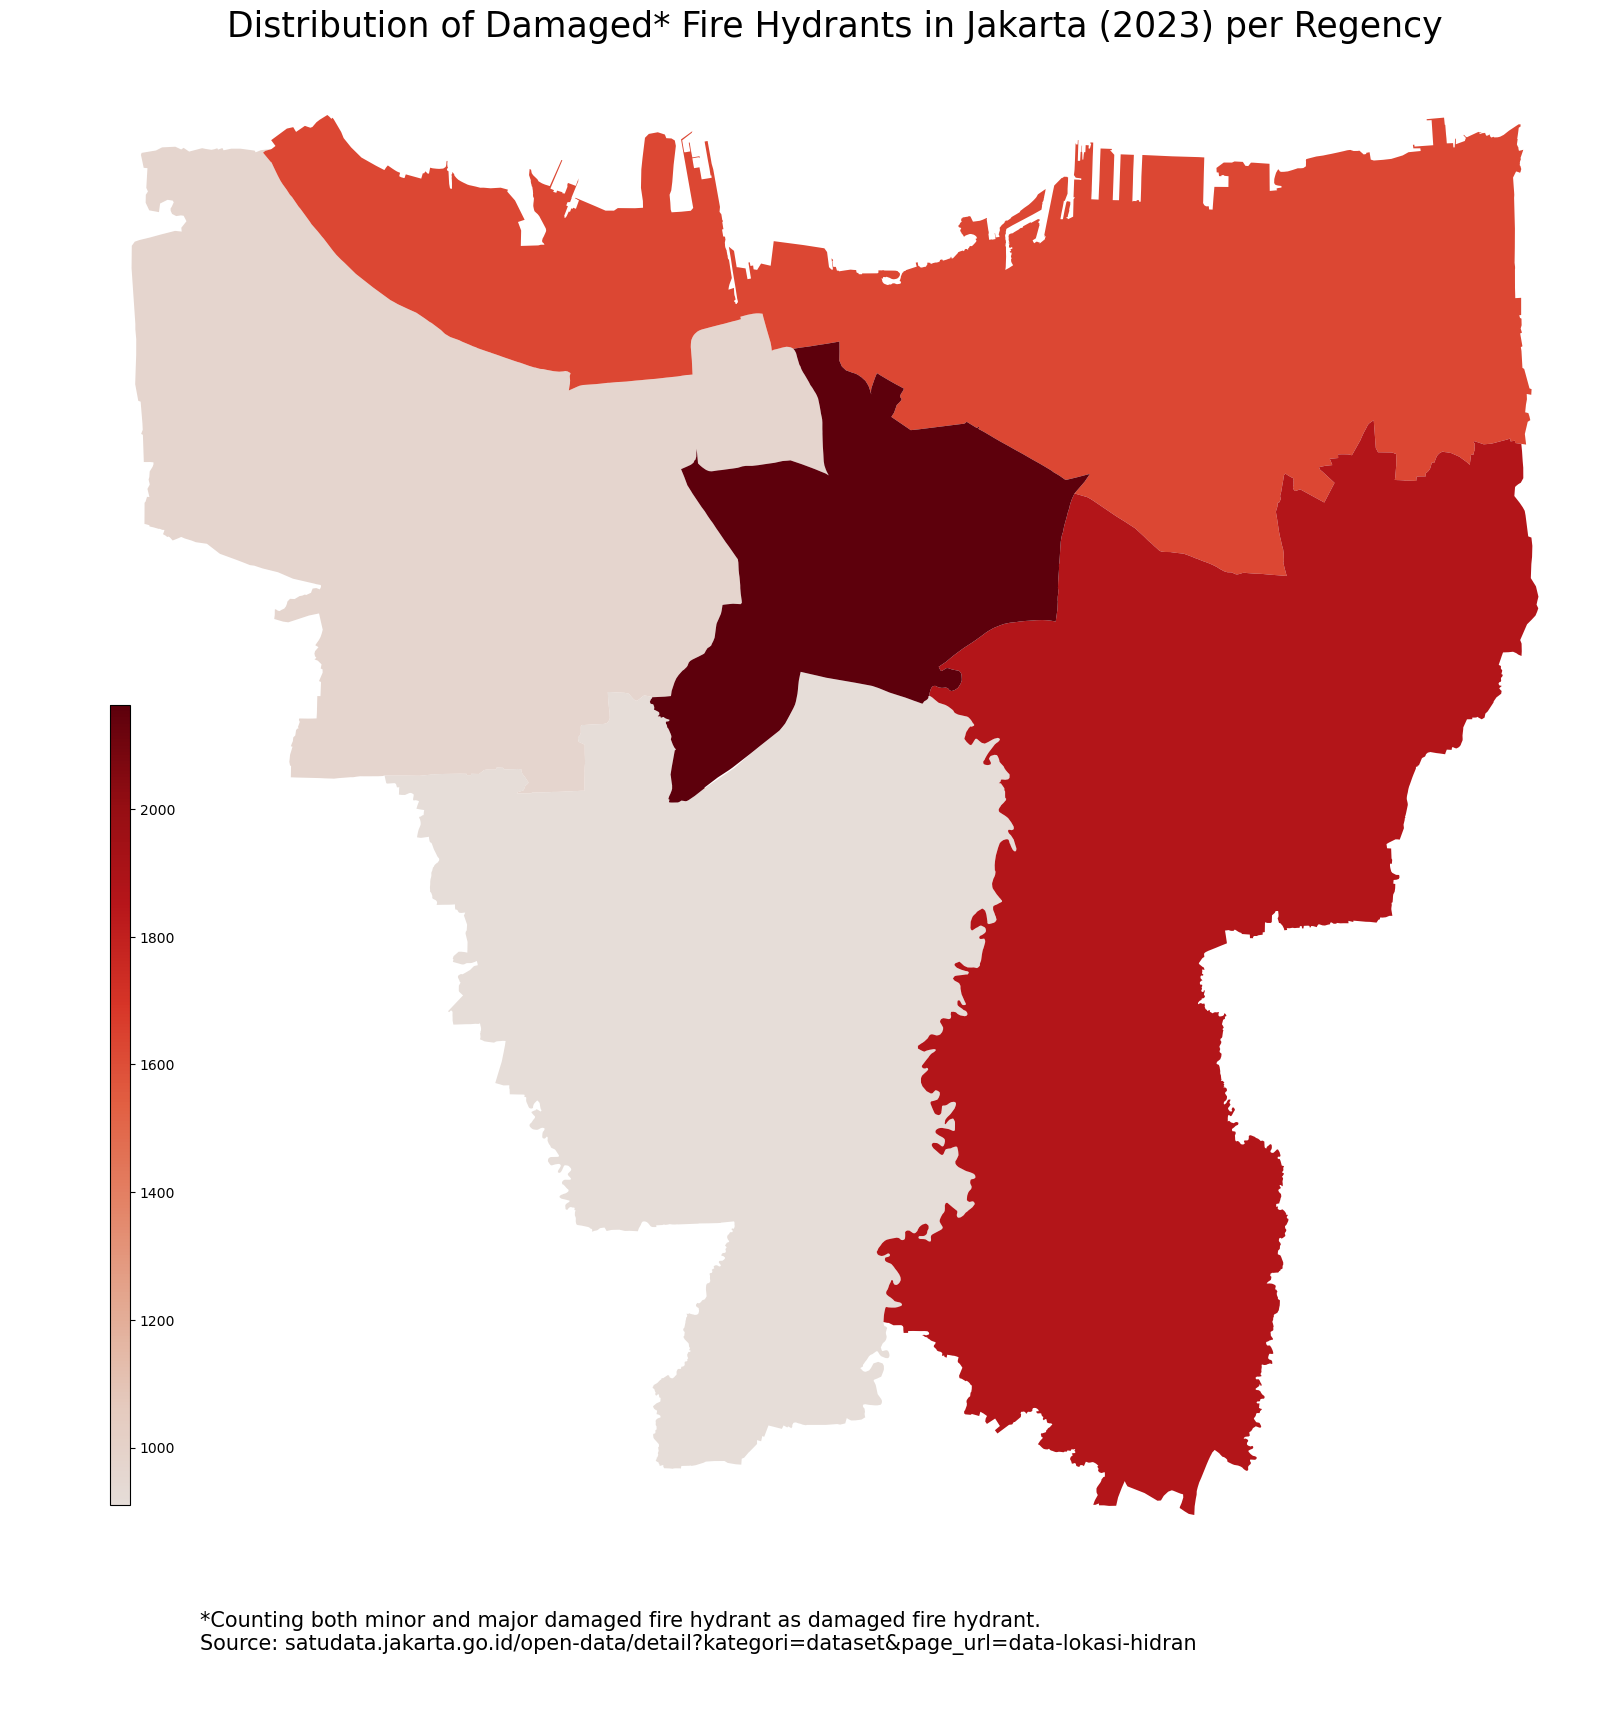

In [31]:
title = 'Distribution of Damaged* Fire Hydrants in Jakarta (2023) per Regency'
col = 'total'
vmin = merged_df_dam['total'].min()
vmax = merged_df_dam['total'].max()

fig_map, ax_map = plt.subplots(figsize = (20,20))
ax_map.axis('off')
merged_df_dam.plot(column = col, ax = ax_map, linewidth = 1, cmap = cmap_d)
ax_map.set_title(title, fontsize = 25)
sm = plt.cm.ScalarMappable(norm= plt.Normalize(vmin = vmin, vmax = vmax), cmap = cmap_d)
cbaxes = fig_map.add_axes([0.15, 0.15, 0.01, 0.4])
cbar = fig_map.colorbar(sm, cax = cbaxes)
ax_map.annotate('*Counting both minor and major damaged fire hydrant as damaged fire hydrant.\nSource: satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-lokasi-hidran', xy = (0.1, .04), xycoords= 'figure fraction', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize = 15)
plt.show()

In [32]:
merged_df_dam

,name,geometry,condition,total
0,South Jakarta,"MULTIPOLYGON (((106.73745 -6.22378, 106.73761 ...",damaged,910
1,West Jakarta,"MULTIPOLYGON (((106.68636 -6.13173, 106.68559 ...",damaged,973
2,North Jakarta,"MULTIPOLYGON (((106.71413 -6.09616, 106.71300 ...",damaged,1626
3,East Jakarta,"MULTIPOLYGON (((106.83972 -6.33514, 106.83975 ...",damaged,1866
4,Central Jakarta,"MULTIPOLYGON (((106.79239 -6.20778, 106.79250 ...",damaged,2163


The choropleth map above shows the distribution of damaged fire hydrant (both minor and major) are concentrated in Central Jakarta. Central Jakarta in total have 2163 damaged fire hydrants.

Second largest amount of damaged fire hydrants are located in East Jakarta, totaling 1866 fire hydrants.

Third largest amount of damaged fire hydrants are located in North Jakarta with total of 1626 fire hydrants.

The smallest amount of damaged fire hydrants are located in South Jakarta with total of 910 fire hydrants.

Both South Jakarta and West Jakarta are lighter colored than the rest of regencies abeit both have around 900 damaged fire hydrants as choropleth map compares the normalized total of the fire hydrants for each regencies.

In [33]:
merged_df_good = merged_df[merged_df['condition'] == 'good'].copy()

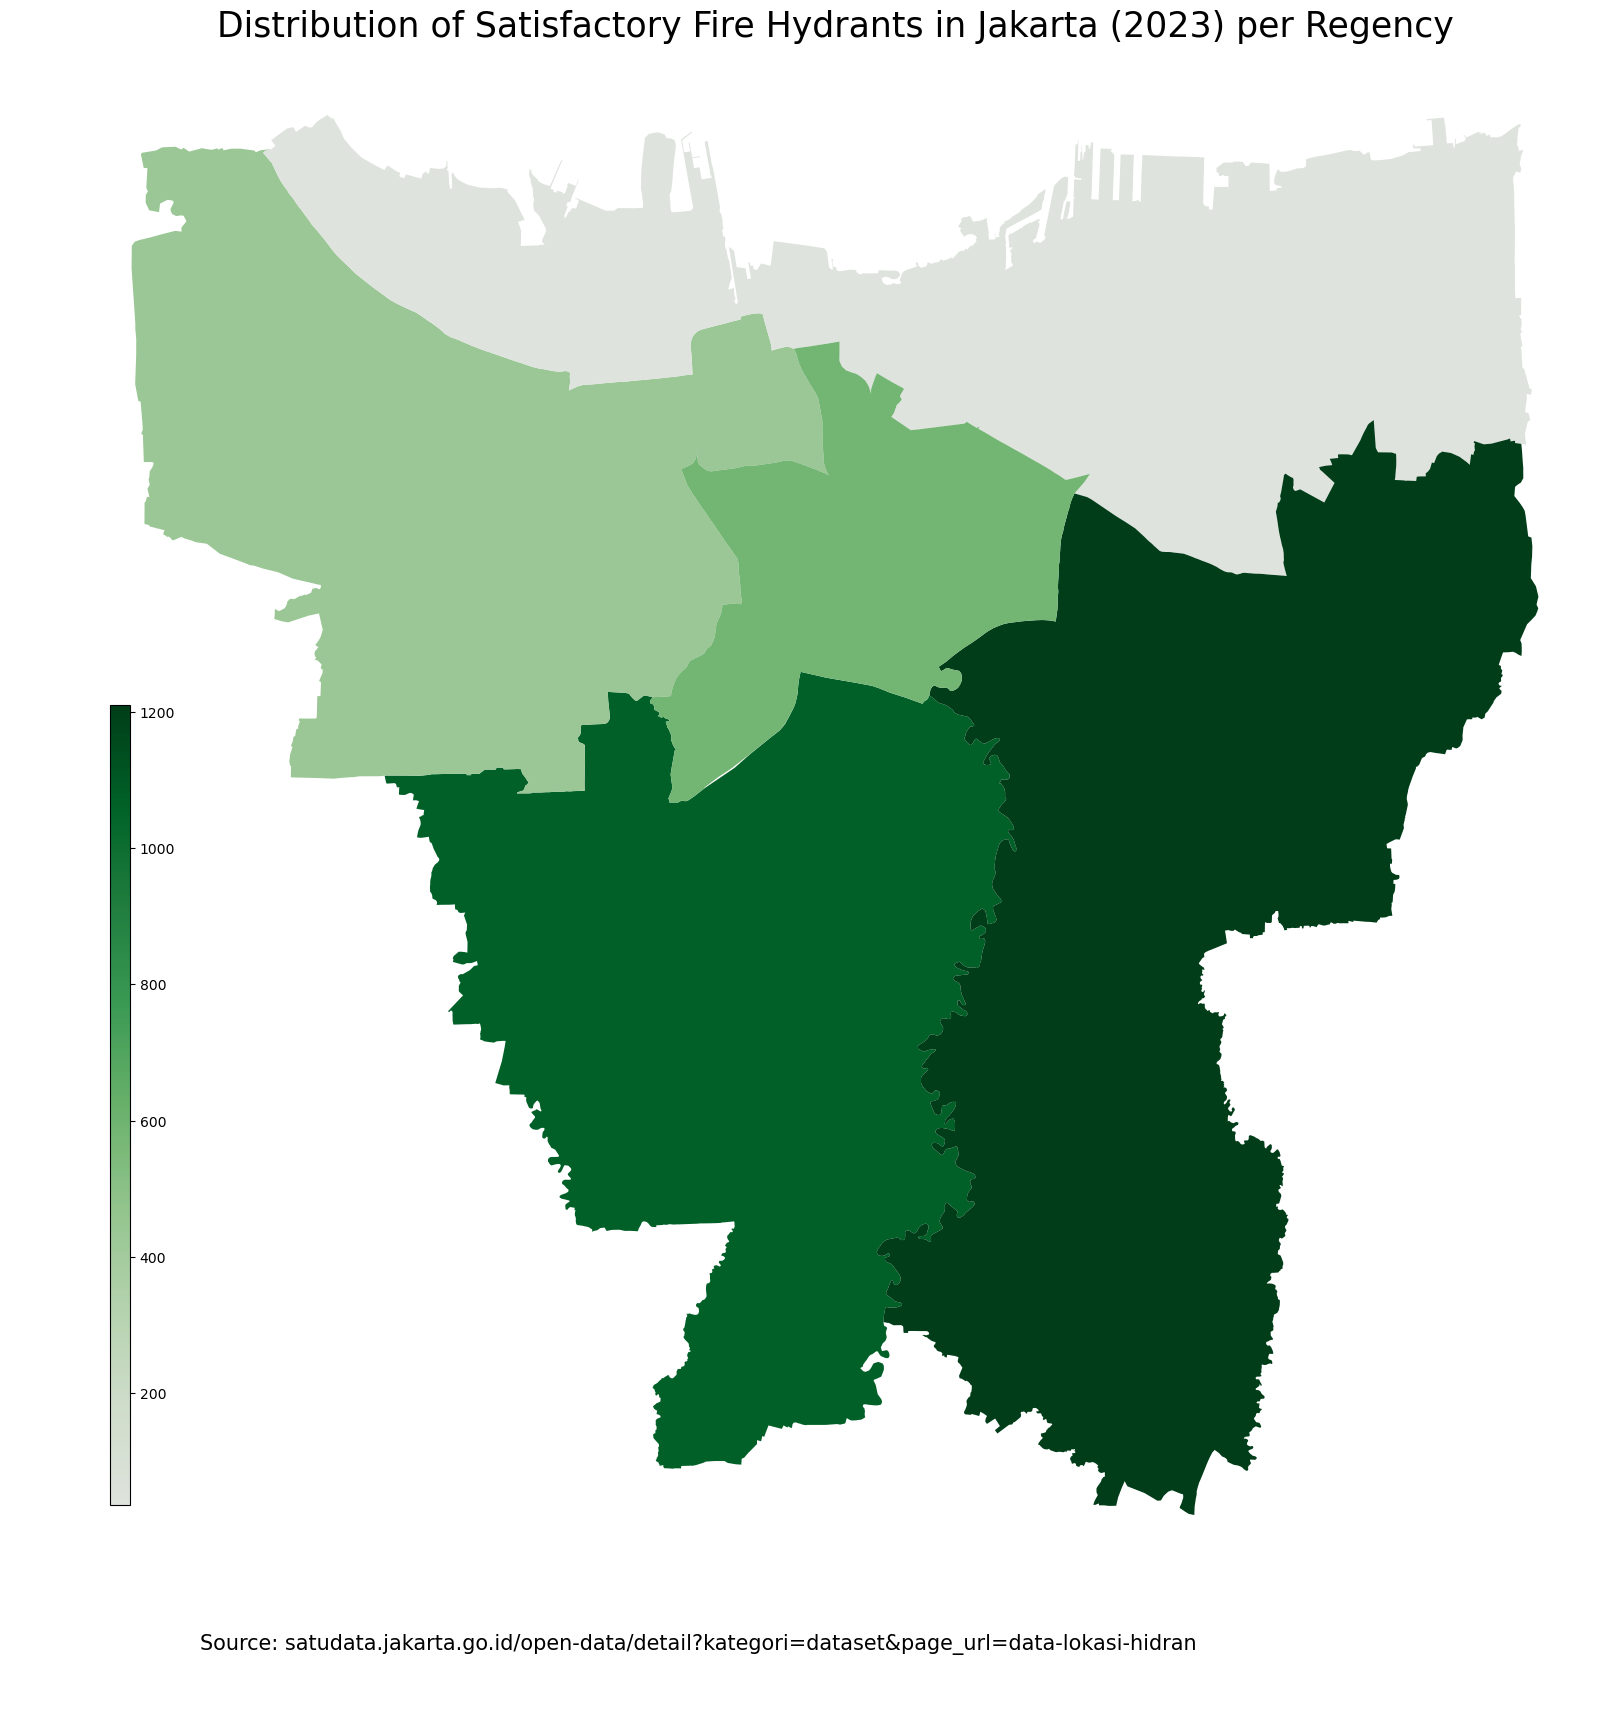

In [34]:
title = 'Distribution of Satisfactory Fire Hydrants in Jakarta (2023) per Regency'
col = 'total'
vmin = merged_df_good['total'].min()
vmax = merged_df_good['total'].max()

fig_map, ax_map = plt.subplots(figsize = (20,20))
ax_map.axis('off')
merged_df_good.plot(column = col, ax = ax_map, linewidth = 1, cmap = cmap_g)
ax_map.set_title(title, fontsize = 25)
sm = plt.cm.ScalarMappable(norm= plt.Normalize(vmin = vmin, vmax = vmax), cmap = cmap_g)
cbaxes = fig_map.add_axes([0.15, 0.15, 0.01, 0.4])
cbar = fig_map.colorbar(sm, cax = cbaxes)
ax_map.annotate('Source: satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-lokasi-hidran', xy = (0.1, .04), xycoords= 'figure fraction', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize = 15)
plt.show()

In [35]:
merged_df_good

,name,geometry,regency,condition,total
0,South Jakarta,"MULTIPOLYGON (((106.73745 -6.22378, 106.73761 ...",South Jakarta,good,1071
2,West Jakarta,"MULTIPOLYGON (((106.68636 -6.13173, 106.68559 ...",West Jakarta,good,438
4,North Jakarta,"MULTIPOLYGON (((106.71413 -6.09616, 106.71300 ...",North Jakarta,good,36
7,East Jakarta,"MULTIPOLYGON (((106.83972 -6.33514, 106.83975 ...",East Jakarta,good,1210
9,Central Jakarta,"MULTIPOLYGON (((106.79239 -6.20778, 106.79250 ...",Central Jakarta,good,586


The choropleth map above shows the distribution of satisfactory fire hydrant are concentrated in East Jakarta. East Jakarta in total have 1210 satisfactory fire hydrants.

Second largest amount of satisfactory fire hydrants are located in South Jakarta, totaling 1071 fire hydrants.

Third largest amount of satisfactory fire hydrants are located in Central Jakarta with total of 586 fire hydrants.

The smallest amount of satisfactory fire hydrants are located in North Jakarta with total of 36 fire hydrants.

### Choropleth Map of Fire Hydrant per District

Loading necessary GeoJSON files for district location information.

In [36]:
geo_df_jakn = gpd.read_file('id-jk-jakut.geojson')
geo_df_jakw = gpd.read_file('id-jk-jakbar.geojson')
geo_df_jakc = gpd.read_file('id-jk-jakpus.geojson')
geo_df_jaks = gpd.read_file('id-jk-jaksel.geojson')
geo_df_jake = gpd.read_file('id-jk-jaktim.geojson')

In [37]:
pd.set_option('display.max_rows', 30)

Combining all GeoJSON dataframes into single dataframe.

In [38]:
geo_df_jak_district = pd.concat([geo_df_jakw, geo_df_jakc, geo_df_jakn, geo_df_jaks, geo_df_jake]).reset_index(drop = True)
geo_df_jak_district['name'] = geo_df_jak_district['name'].str.capitalize()
geo_df_jak_district = geo_df_jak_district.sort_values('name').reset_index(drop = True)

Checking for mismatch about district in GeoJSON with fire hydrant dataset.

In [39]:
geo_df_jak_district[~geo_df_jak_district['name'].isin(district_df['district'].unique())]

,name,geometry
5,Cipayung,"MULTIPOLYGON (((106.88237 -6.29880, 106.88288 ..."
10,Jagakarsa,"MULTIPOLYGON (((106.79395 -6.35421, 106.79400 ..."


Cipayung and Jagakarsa districts are missing from the fire hydrant dataset. Both of the districts will be left as blanks in choropleth map.

In [40]:
district_df = pd.DataFrame(df_2023.groupby(['district'])['condition'].value_counts().rename_axis(['district', 'condition'])).rename(columns = {'condition': 'total'}).copy().reset_index(level = ['district', 'condition'])
district_df_g = district_df[district_df['condition'] == 'good'].copy().reset_index(drop = True)
district_df_g.sort_values('district')

,district,condition,total
0,Cakung,good,149
1,Cengkareng,good,43
2,Cilandak,good,104
3,Cilincing,good,18
4,Ciracas,good,52
...,...,...,...
29,Taman sari,good,70
30,Tambora,good,10
31,Tanah abang,good,9
32,Tanjung priok,good,9


In [41]:
merged_df_dg = pd.merge(left = geo_df_jak_district, right = district_df_g, how = 'right', left_on = 'name', right_on = 'district')

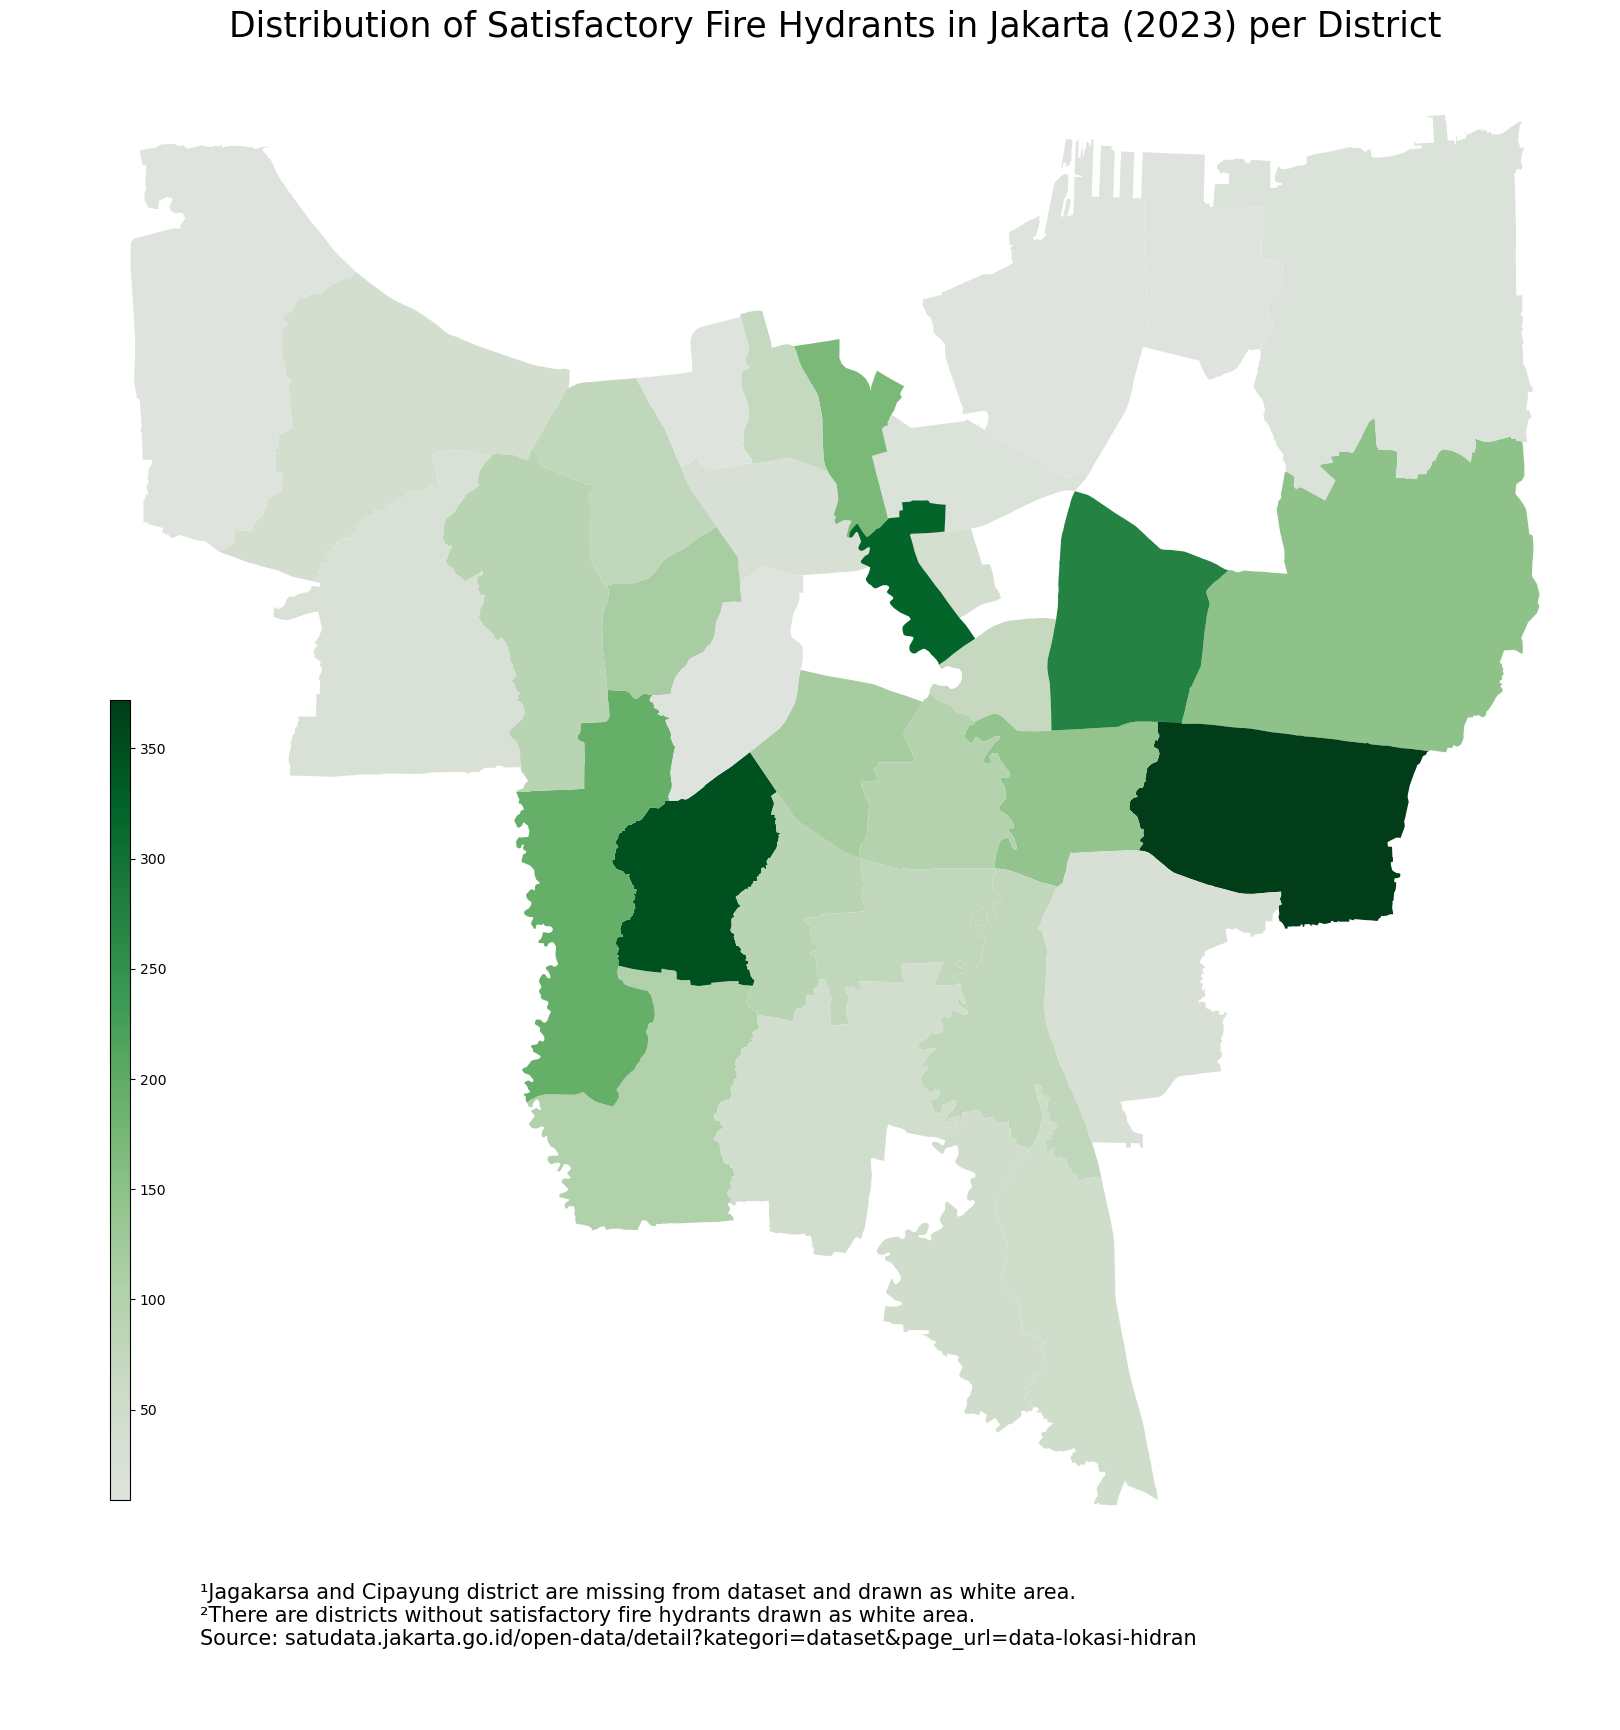

In [42]:
title = 'Distribution of Satisfactory Fire Hydrants in Jakarta (2023) per District'
col = 'total'
vmin = merged_df_dg['total'].min()
vmax = merged_df_dg['total'].max()

fig_map, ax_map = plt.subplots(figsize = (20,20))
ax_map.axis('off')
merged_df_dg.plot(column = col, ax = ax_map, linewidth = 1, cmap = cmap_g)
ax_map.set_title(title, fontsize = 25)
sm = plt.cm.ScalarMappable(norm= plt.Normalize(vmin = vmin, vmax = vmax), cmap = cmap_g)
cbaxes = fig_map.add_axes([0.15, 0.15, 0.01, 0.4])
cbar = fig_map.colorbar(sm, cax = cbaxes)
ax_map.annotate('\u00b9Jagakarsa and Cipayung district are missing from dataset and drawn as white area.\n\u00b2There are districts without satisfactory fire hydrants drawn as white area.\nSource: satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-lokasi-hidran', xy = (0.1, .04), xycoords= 'figure fraction', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize = 15)
plt.show()

In [43]:
merged_df_dg.sort_values('total', ascending = False)

,name,geometry,district,condition,total
5,Duren sawit,"MULTIPOLYGON (((106.89004 -6.23041, 106.89005 ...",Duren sawit,good,372
11,Kebayoran baru,"MULTIPOLYGON (((106.78471 -6.24078, 106.78472 ...",Kebayoran baru,good,347
27,Senen,"MULTIPOLYGON (((106.83279 -6.17577, 106.83272 ...",Senen,good,322
25,Pulo gadung,"MULTIPOLYGON (((106.87325 -6.20231, 106.87325 ...",Pulo gadung,good,273
12,Kebayoran lama,"MULTIPOLYGON (((106.76447 -6.23267, 106.76472 ...",Kebayoran lama,good,192
...,...,...,...,...,...
30,Tambora,"MULTIPOLYGON (((106.78898 -6.14329, 106.79011 ...",Tambora,good,10
16,Koja,"MULTIPOLYGON (((106.89249 -6.10555, 106.89322 ...",Koja,good,9
31,Tanah abang,"MULTIPOLYGON (((106.79239 -6.20778, 106.79250 ...",Tanah abang,good,9
32,Tanjung priok,"MULTIPOLYGON (((106.84772 -6.12852, 106.84770 ...",Tanjung priok,good,9


As shown in choropleth of satisfactory fire hydrants above, good number of districts in North Jakarta are missing. This is in line with data exploration above that the majority of fire hydrants in North Jakarta are damaged.

District with highest amount of satisfactory fire hydrants are Duren Sawit, which is located in East Jakarta, followed by Kebayoran Baru in South Jakarta, and third highest is Senen which is located in Central Jakarta.

The highest distribution of satisfactory fire hydrant is concentrated on East Jakarta, in line with the choropleth map of satifactory fire hydrants per regency abeit with missing district.

In [44]:
district_df_b = district_df[district_df['condition'] != 'good'].copy().reset_index(drop = True).copy()
district_df_b.replace(['minor damage', 'major damage'], ['damage', 'damage'], inplace = True)
district_df_b = district_df_b.groupby(['district']).sum(numeric_only= True).reset_index()

In [45]:
merged_df_db = pd.merge(left = geo_df_jak_district, right = district_df_b, how = 'right', left_on = 'name', right_on = 'district')

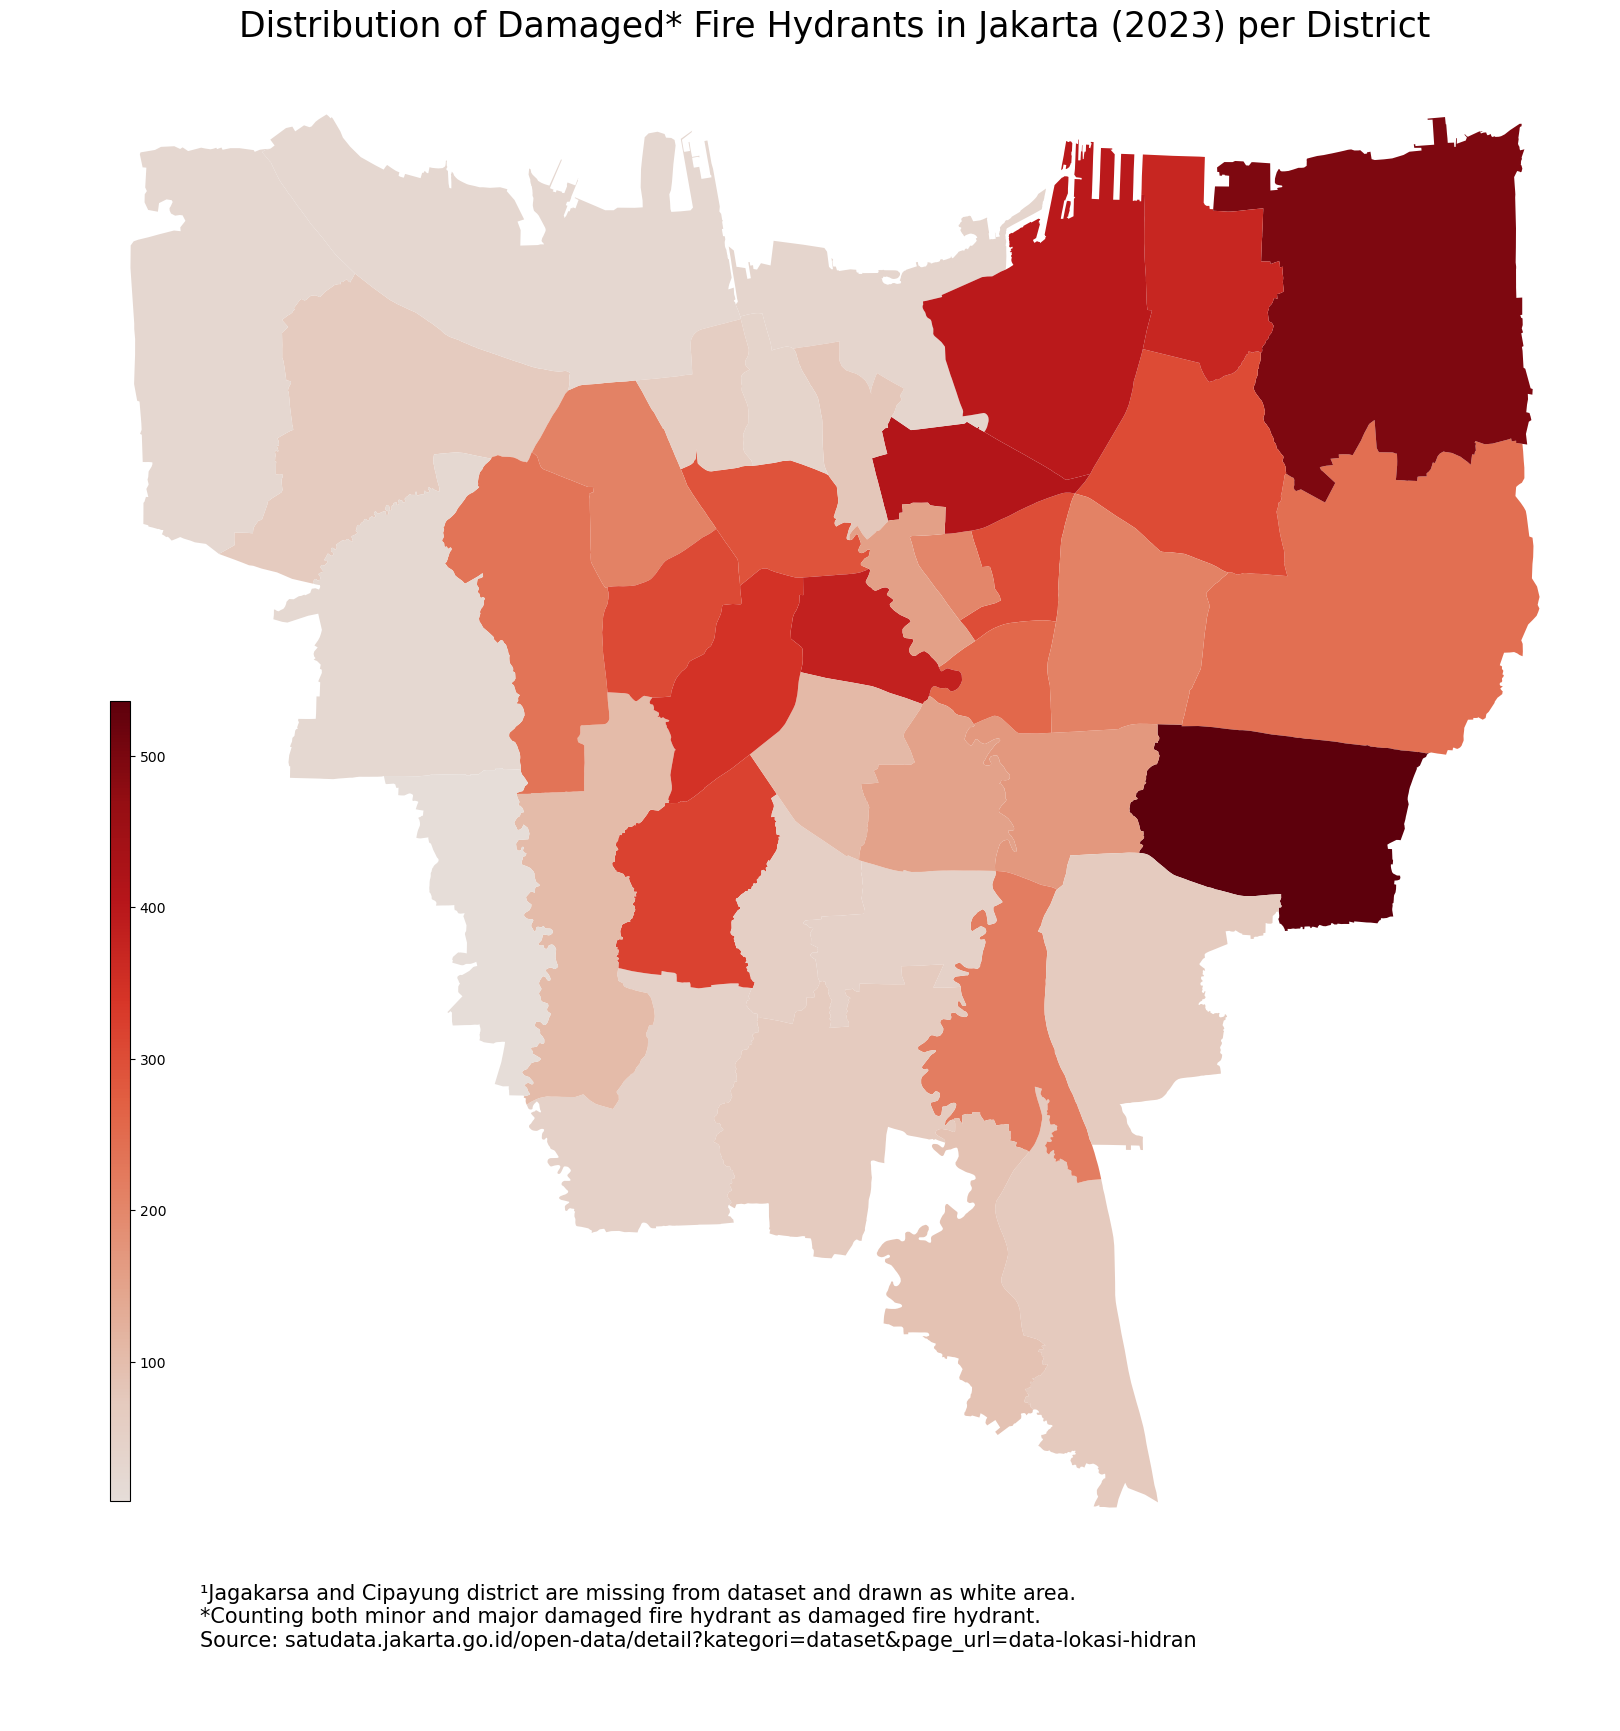

In [46]:
title = 'Distribution of Damaged* Fire Hydrants in Jakarta (2023) per District'
col = 'total'
vmin = merged_df_db['total'].min()
vmax = merged_df_db['total'].max()

fig_map, ax_map = plt.subplots(figsize = (20,20))
ax_map.axis('off')
merged_df_db.plot(column = col, ax = ax_map, linewidth = 1, cmap = cmap_d)
ax_map.set_title(title, fontsize = 25)
sm = plt.cm.ScalarMappable(norm= plt.Normalize(vmin = vmin, vmax = vmax), cmap = cmap_d)
cbaxes = fig_map.add_axes([0.15, 0.15, 0.01, 0.4])
cbar = fig_map.colorbar(sm, cax = cbaxes)
ax_map.annotate('\u00b9Jagakarsa and Cipayung district are missing from dataset and drawn as white area.\n*Counting both minor and major damaged fire hydrant as damaged fire hydrant.\nSource: satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-lokasi-hidran', xy = (0.1, .04), xycoords= 'figure fraction', horizontalalignment = 'left', verticalalignment = 'bottom', fontsize = 15)
plt.show()

In [47]:
merged_df_db.sort_values('total', ascending = False)

,name,geometry,district,total
6,Duren sawit,"MULTIPOLYGON (((106.89004 -6.23041, 106.89005 ...",Duren sawit,536
4,Cilincing,"MULTIPOLYGON (((106.90716 -6.10877, 106.90718 ...",Cilincing,495
16,Kemayoran,"MULTIPOLYGON (((106.83735 -6.15913, 106.83790 ...",Kemayoran,411
38,Tanjung priok,"MULTIPOLYGON (((106.84772 -6.12852, 106.84770 ...",Tanjung priok,396
23,Menteng,"MULTIPOLYGON (((106.82070 -6.19433, 106.82087 ...",Menteng,380
...,...,...,...,...
24,Pademangan,"MULTIPOLYGON (((106.80939 -6.12767, 106.80969 ...",Pademangan,36
29,Penjaringan,"MULTIPOLYGON (((106.71413 -6.09616, 106.71300 ...",Penjaringan,27
11,Kalideres,"MULTIPOLYGON (((106.68636 -6.13173, 106.68559 ...",Kalideres,27
17,Kembangan,"MULTIPOLYGON (((106.71483 -6.19187, 106.71494 ...",Kembangan,25


District with highest amount of damaged fire hydrants are Duren Sawit, which is located in East Jakarta, followed by Cilincing in North Jakarta, and third highest is Kemayoran which is located in Central Jakarta.

At first glance it might seem odd both damaged and satisfactory fire hydrants are located in Duren Sawit but it is possible as East Jakarta have the largest amount of fire hydrants of all regencies and according to dataframe of total count of fire hydrants both satisfactory and damaged  it does fit the choropleth map.

The highest distribution of damaged fire hydrant is concentrated on Central Jakarta, in line with the choropleth map of damaged fire hydrants per regency abeit the highest amount is located in East Jakarta.

# Conclusion

- Majority of fire hydrants (63% of all fire hydrants) had sustained minor damage. 
- Highest amount of damaged fire hydrant is located in Central Jakarta with 2163 damaged fire hydrants (1618 minor damage and 545 major damage).
- Highest amount of satisfactory fire hydrants is located in East Jakarta with 1210 satisfactory fire hydrants.
- Both highest amount of damaged and satisfactory fire hydrants of all districts are Duren Sawit with 536 damaged fire hydrants and 372 satisfactory fire hydrants.

# Source
- Dataset: [Fire Hydrant Dataset](https://satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=data-lokasi-hidran)
- GeoJSON: [GeoJSON of Jakarta, Jogjakarta, and East Java](https://github.com/thetrisatria/geojson-indonesia?)